In [1]:
import os
import sys
sys.path.append("/home/pervinco/BKAI-NeoPolyp")

import cv2
import yaml
import torch
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from data.BKAIDataset import BKAIDataset
from utils import decode_mask, decode_image, visualize


In [2]:
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

## Device Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_workers = min([os.cpu_count(), config["batch_size"] if config["batch_size"] > 1 else 0, 8])

In [3]:
data_dir = config["data_dir"]
image_dir = f"{data_dir}/train"
mask_dir = f"{data_dir}/train_mask"
text_path = f"{data_dir}/train.txt"

with open(text_path, "r") as f:
    files = [x.strip() for x in f.readlines()]

print(len(files))

800


In [4]:
file_name = files[0]

image = cv2.imread(f"{image_dir}/{file_name}.jpeg")
mask = cv2.imread(f"{mask_dir}/{file_name}.jpeg")

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

In [5]:
aug = A.Compose([A.VerticalFlip(p=1),
                 A.RandomRotate90(p=0.5)])

augmented = aug(image=image, mask=mask)
image_light = augmented['image']
mask_light = augmented['mask']

# visualize([image, image_light], [mask, mask_light])


In [6]:
train_dataset = BKAIDataset(config=config, split=config["train"])
train_dataloader = DataLoader(dataset=train_dataset, batch_size=1, shuffle=True, num_workers=num_workers)

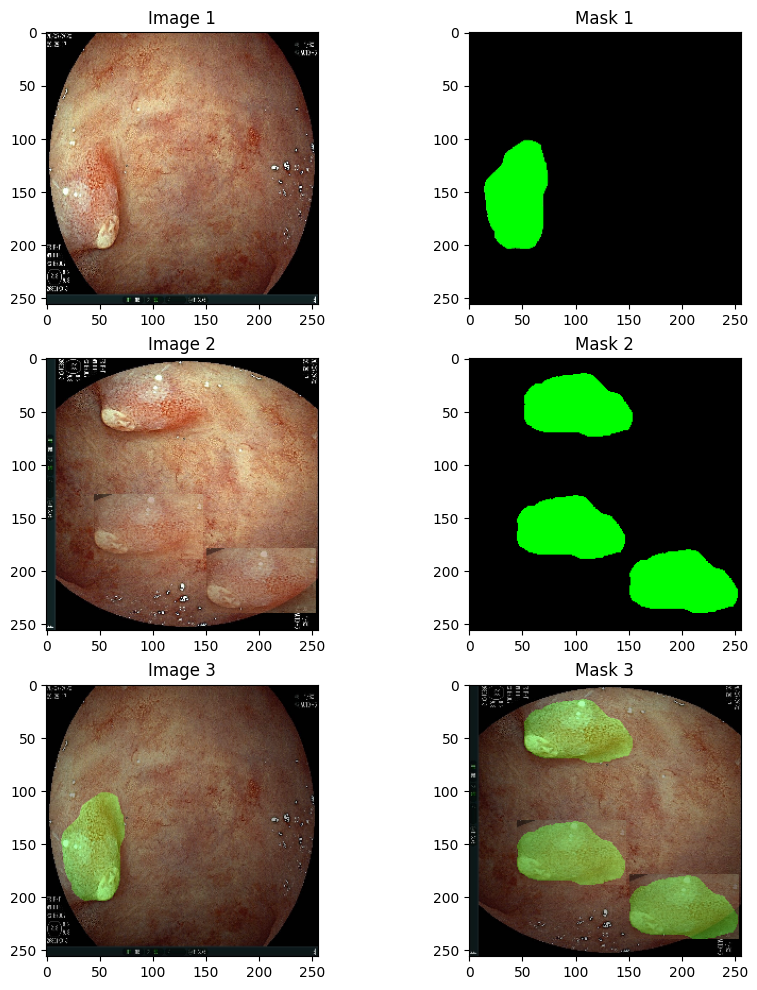

In [10]:
for original_image, original_mask, transform_image, transform_mask in train_dataloader:
    original_image, original_mask = original_image.numpy()[0], original_mask.numpy()[0]
    transform_image, transform_mask = transform_image.numpy()[0], transform_mask.numpy()[0]

    transform_image = decode_image(transform_image)
    transform_mask = decode_mask(transform_mask)

    original_overlay = cv2.addWeighted(original_image, 0.7, original_mask, 0.3, 0)
    transform_overlay = cv2.addWeighted(transform_image, 0.7, transform_mask, 0.3, 0)

    visualize([original_image, transform_image, original_overlay], [original_mask, transform_mask, transform_overlay])

    break